# Visualizing Neptune Results

In [62]:
import neptune.new as neptune
import pandas as pd
from joblib import dump, load
import numpy as np
import sys
import os

# Inserts the package root "modeling-pipeline" into the python path
sys.path.insert(0, os.path.abspath('../..'))
from custom_dataset import MakeTurnsDataset

In [17]:
import matplotlib.pyplot as plt
def show_df(df,name):
    for l in ['at','ang','syncnet', 'perfectmatch']:
        df[l] = df[l].astype(str)
        df.loc[df[l]=="1",l] = l[:5]
    # display(df.head())
    labels = ['perfectmatch', 'syncnet','ang','at']
    fig, ax = plt.subplots(figsize=(15,10))
    boxplot = df.boxplot(column=["metrics/test/speaking-auROC-set"], by=labels, ax = ax, rot=90, fontsize=15)
    plt.savefig(f"{name}-auROC.png")
    plt.show()
    fig, ax = plt.subplots(figsize=(15,10))
    boxplot = df.boxplot(column=["metrics/test/speaking-f1-score-set"], by=labels, ax = ax, rot=90, fontsize=15)
    plt.savefig(f"{name}-F1.png")
    plt.show()
#     fig, ax = plt.subplots(figsize=(15,10))
#     boxplot = df.boxplot(column=["logs/best_so_far_run_score"], by=labels, ax = ax, rot=90, fontsize=15)
#     plt.savefig(f"{name}-best.png")

In [49]:
def get_run(run_id):
    run = neptune.init(project='cmbirmingham/cross-validate-asd', run=run_id, api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkMGNhYTRlNi1mYTZhLTQzYzctODNmYi1iNjE4ZGNmZTA2MTkifQ==")
    return run

def get_run_max(run_id, metric):
    run = get_run(run_id)
    values={}
    if type(metric) == str:
        metric = [metric]
    for m in metric:
        try:
            values[m] = run[m].fetch_values().value
            #print(values)
        except Exception as e:
            print(run_id, e)
            values[m] = [0]
    run.stop()
    r = [max(v) for k,v in values.items()]
    assert len(r) == len(metric), print(r, metric)
    print(r)
    return r[:]

def get_run_set(run_id, metric):
    run = get_run(run_id)
    values={}
    if type(metric) == str:
        metric = [metric]
    for m in metric:
        try:
            values[m] = run[m].fetch_values().value
            #print(values)
        except Exception as e:
            print(run_id, e)
            values[m] = [0]
    run.stop()
    r = [list(v) for k,v in values.items()]
    assert len(r) == len(metric), print(r, metric)
    # print(r)
    return r[:]


def get_model(run_id):
    run = get_run(run_id)
    run['artifacts/model.pt'].download(destination='model.pt') 
    run.stop()
    clf = load("model.pt")   
    # clf.predict(np.random.rand(20,25*4))
    return clf

# v = get_run_set('AC1-76',["metrics/test/speaking-f1-score","metrics/test/speaking-auROC"])


# Visualizing Feature Importance

In [134]:
def plot_table(table, metric):
    labels = list(table["tags"])
    data = list(table[metric])
    for i in range(len(data)):
        assert len(data[i]) == 9, f"must have all nine rotations, {len(data[i])}, {labels[i]}, {data[i]}"
    data = [[d for d in s if d !=0] for s in data]
    
    zipped = zip(labels, data)
    zipped = list(zipped)
    zipped = sorted(zipped, key = lambda x: len(x[0]))
    labels = [x[0] for x in zipped]
    data = [x[1] for x in zipped]
    fig = plt.figure(figsize =(20, 4))

    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])

    # Creating plot
    # bp = ax.boxplot(data)
    #bp = ax.boxplot(data, patch_artist = False,
    #                notch ='False', vert = 0)
    ax.violinplot(data, showmeans=True, showextrema=True, vert=0, widths=1)
    ax.set_yticks(np.arange(len(labels))+1)
    ax.set_xticks([i/40 for i in range(40)])
    ax.set_yticklabels(labels)
    # show plot
    plt.title(metric)
    plt.grid(True)
    plt.show()
    
def get_table(model, window, metrics):
    table = project.fetch_runs_table(tag=[window,model]).to_pandas()
    table["tags"] = table["sys/tags"].apply(lambda x: [y for y in x.split(',') if y not in ["laptop", model, window]])
    series = table['sys/id'].apply(lambda x: get_run_set(x, metrics))
    tmp = pd.DataFrame(series.tolist(), columns=[m+"-set" for m in metrics])
    table=table.join(tmp)
    return table

metrics = [f"metrics/{s}/speaking-f1-score" for s in ["val","test"]] + [f"metrics/{s}/speaking-auROC" for s in ["val","test"]]


In [95]:
project = neptune.get_project('cmbirmingham/cross-validate-asd', api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkMGNhYTRlNi1mYTZhLTQzYzctODNmYi1iNjE4ZGNmZTA2MTkifQ==")

### To Run
[X] GRU 25
[X] GRU 12
[X] GRU 5 - Updating
[X] XGB 25
[X] XGB 12
[X] XGB 5
[ ] TCN 25 - Running
[X] TCN 12
[ ] TCN 5 - Running

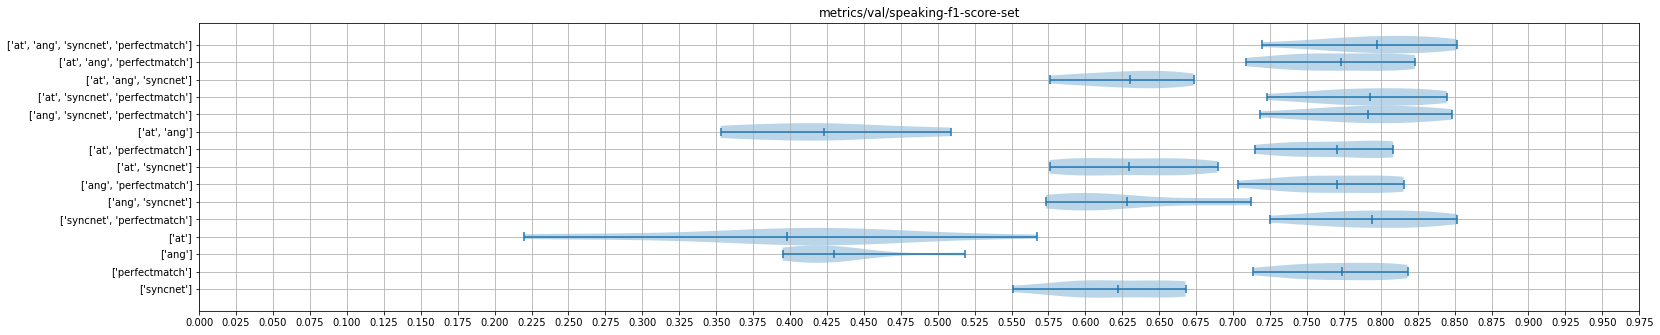

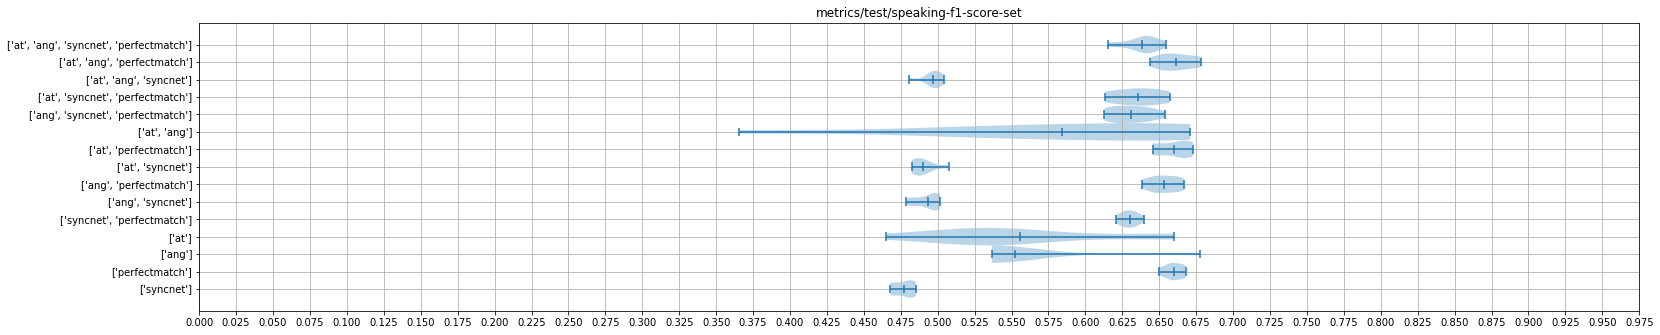

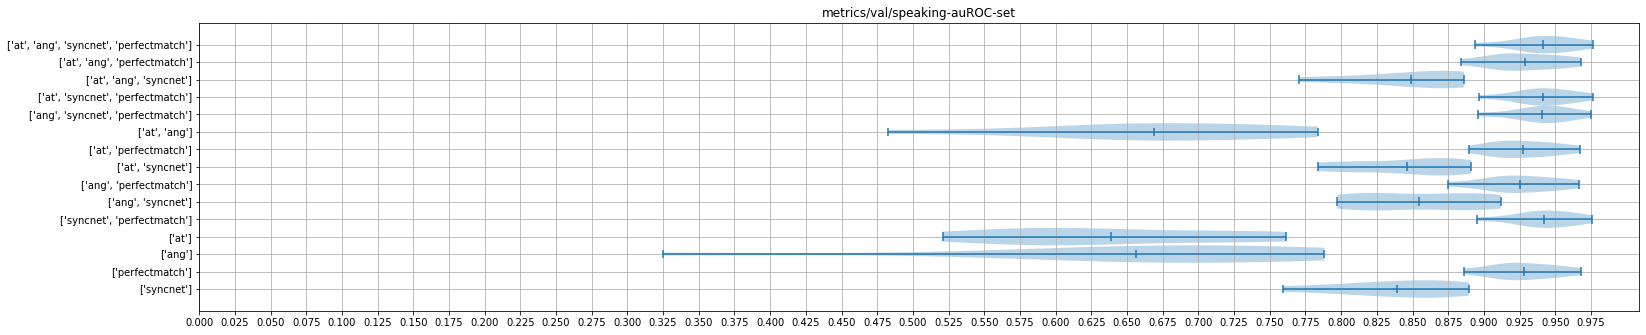

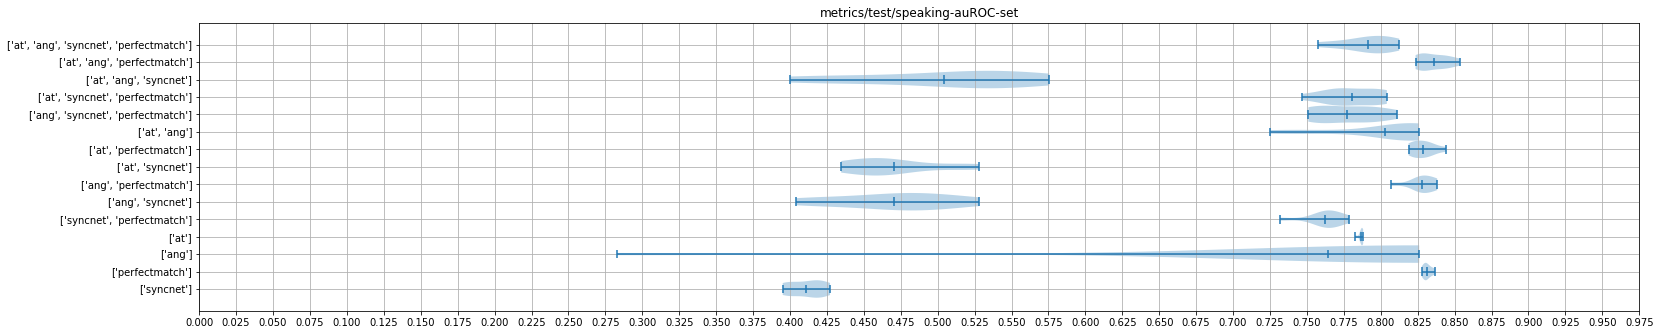

In [135]:
# gru_25_table = get_table("gru", "25", metrics)
for m in metrics:
    plot_table(gru_25_table,m+"-set")

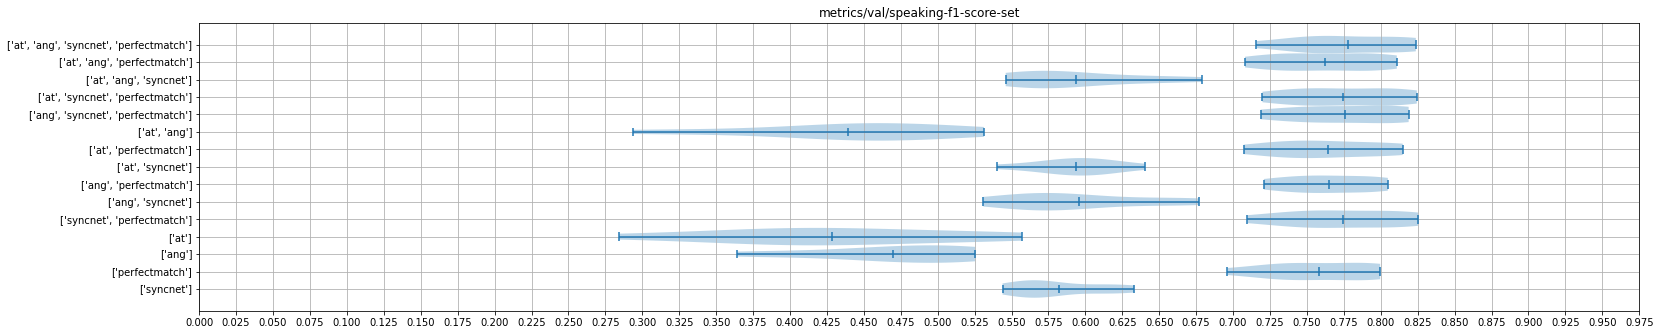

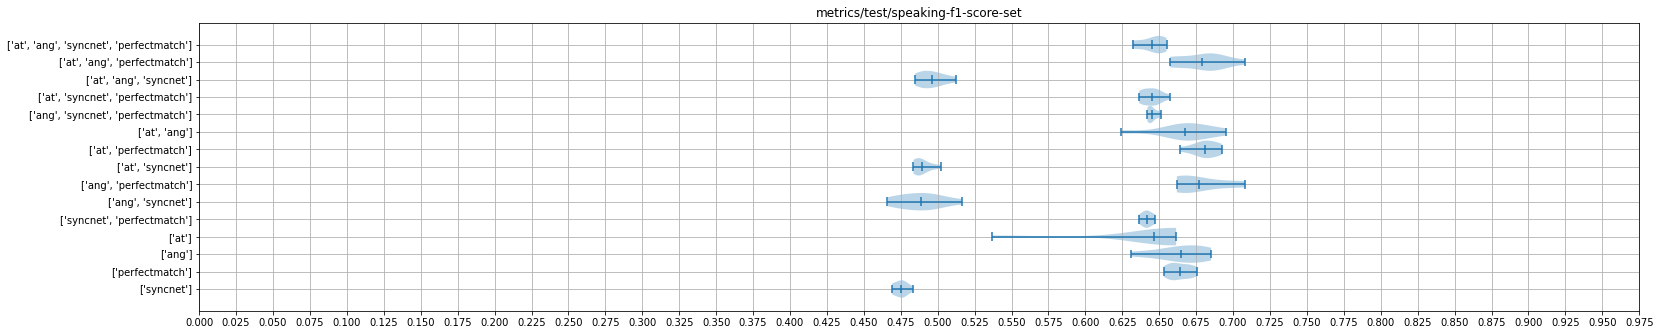

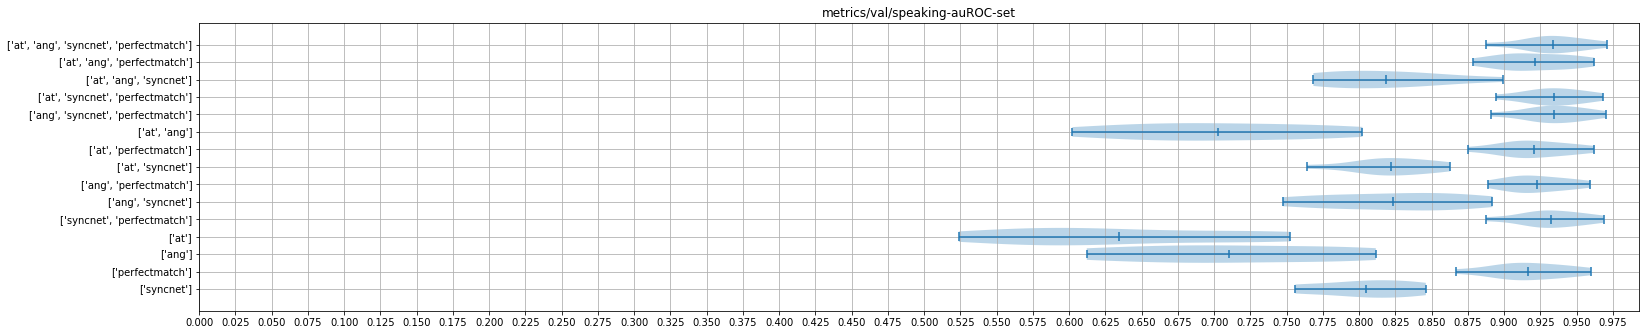

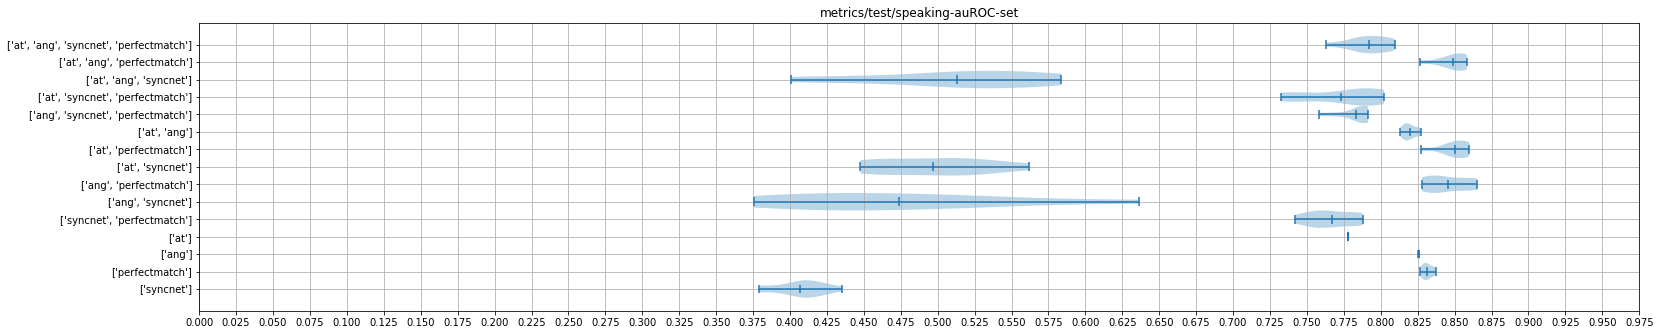

In [136]:
# gru_12_table = get_table("gru", "12", metrics)
for m in metrics:
    plot_table(gru_12_table,m+"-set")

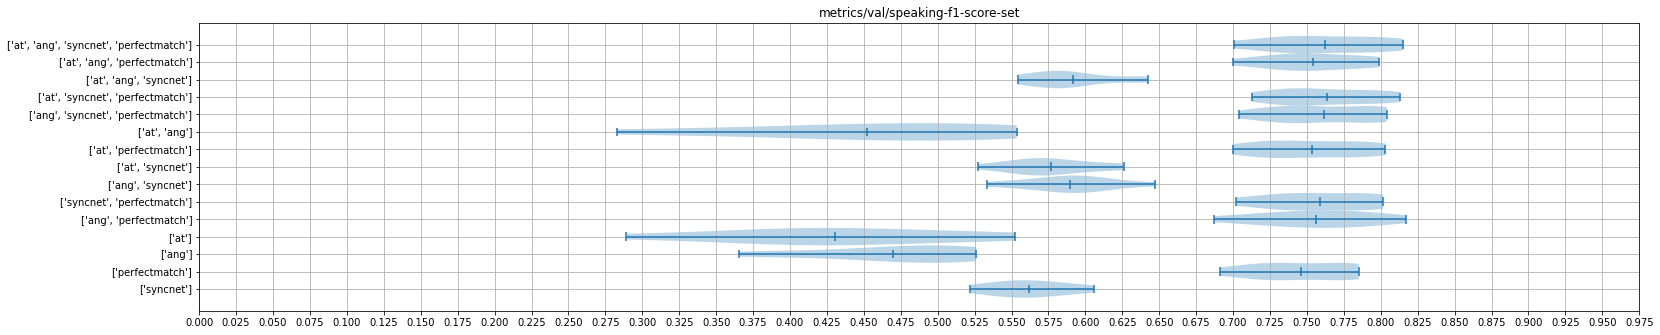

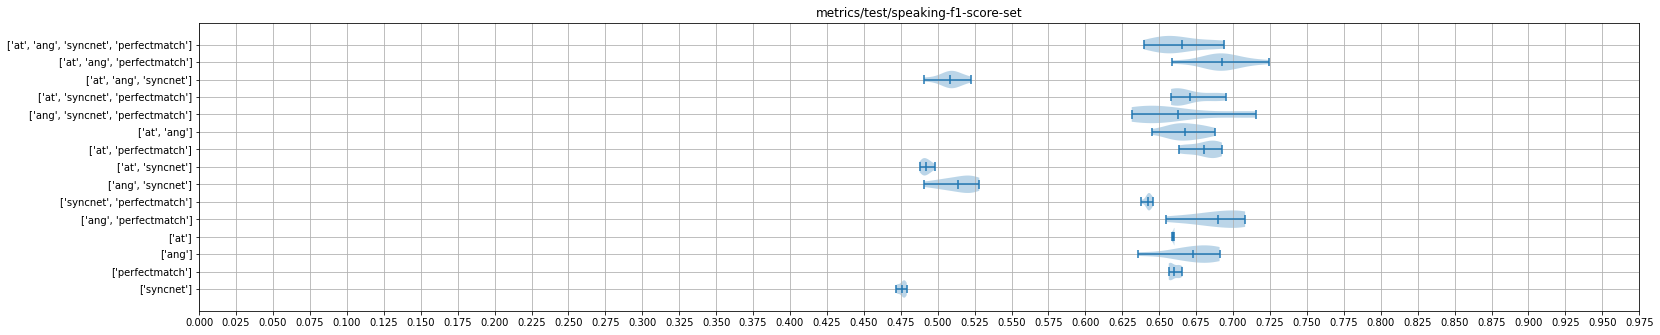

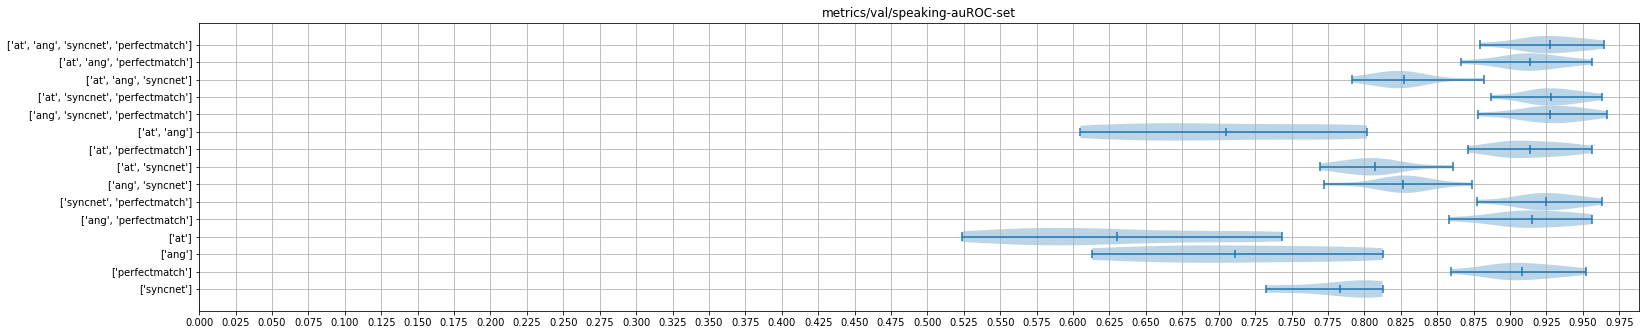

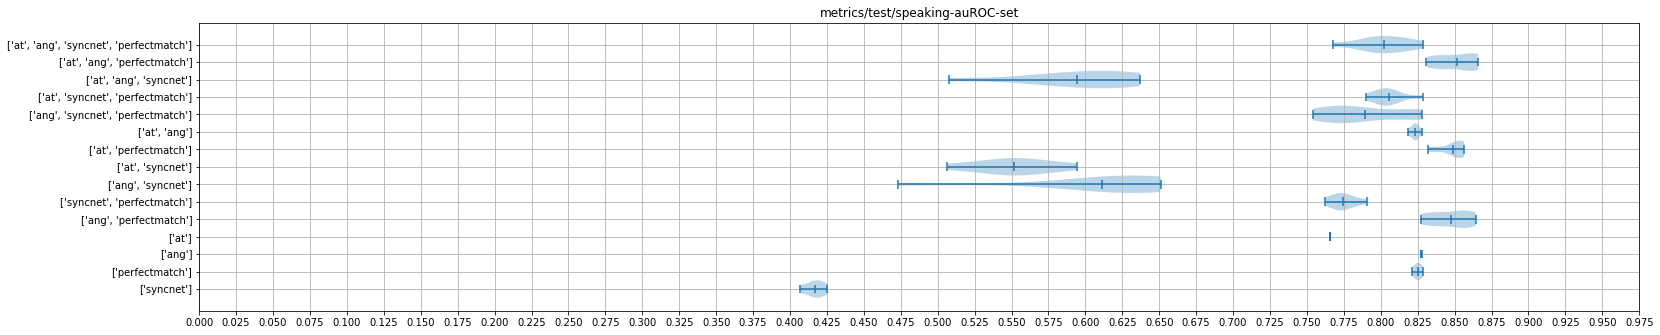

In [143]:
# gru_5_table = get_table("gru", "5", metrics)
for m in metrics:
    plot_table(gru_5_table,m+"-set")

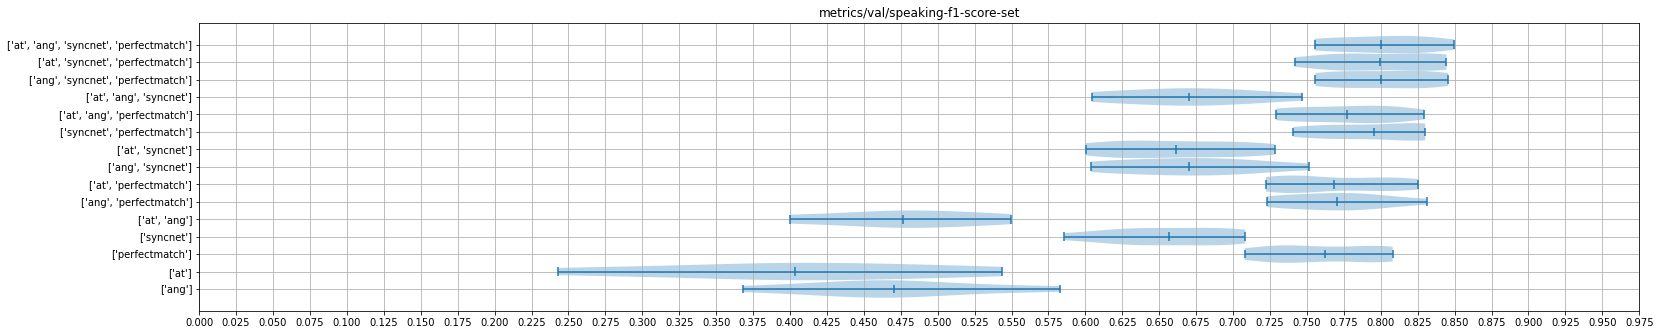

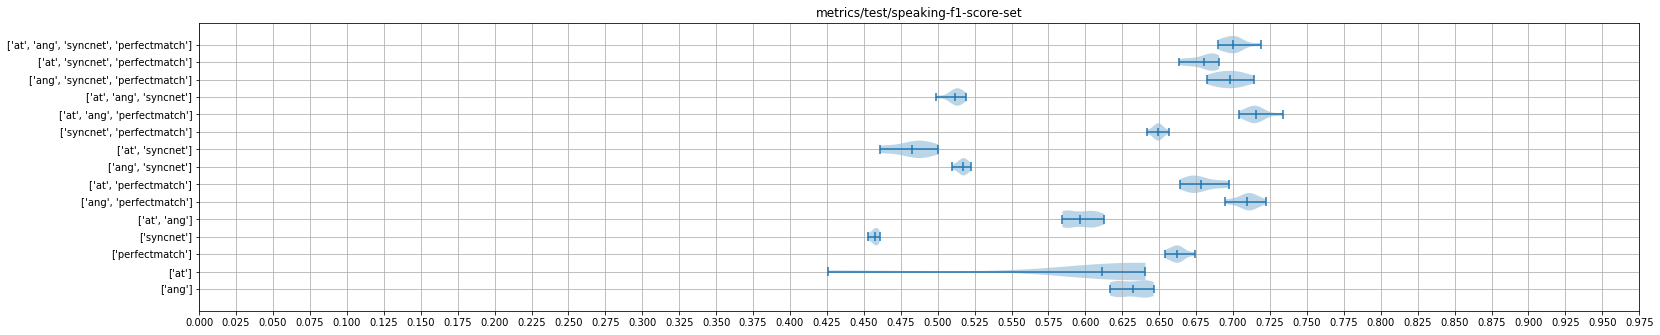

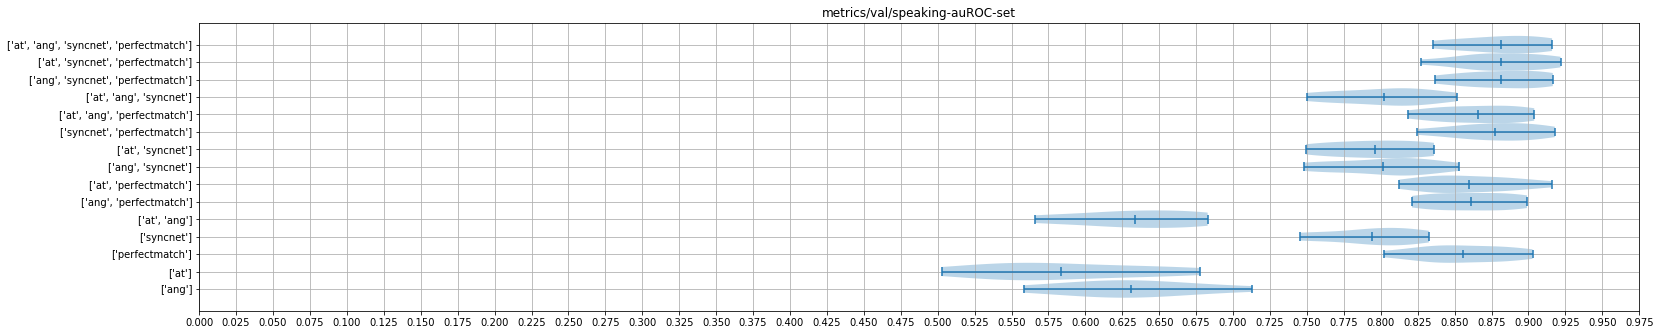

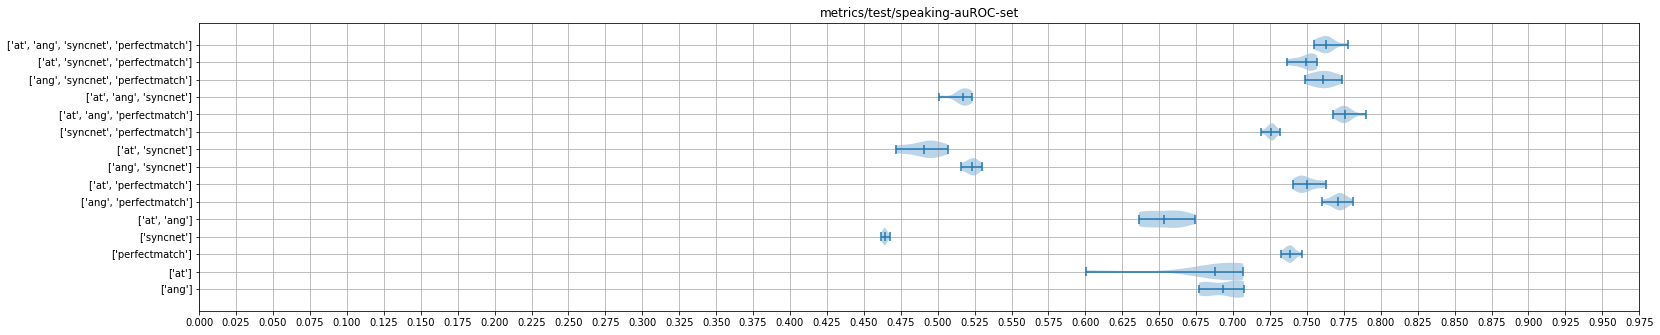

In [137]:
# xgb_25_table = get_table("xgb", "25", metrics)
for m in metrics:
    plot_table(xgb_25_table,m+"-set")

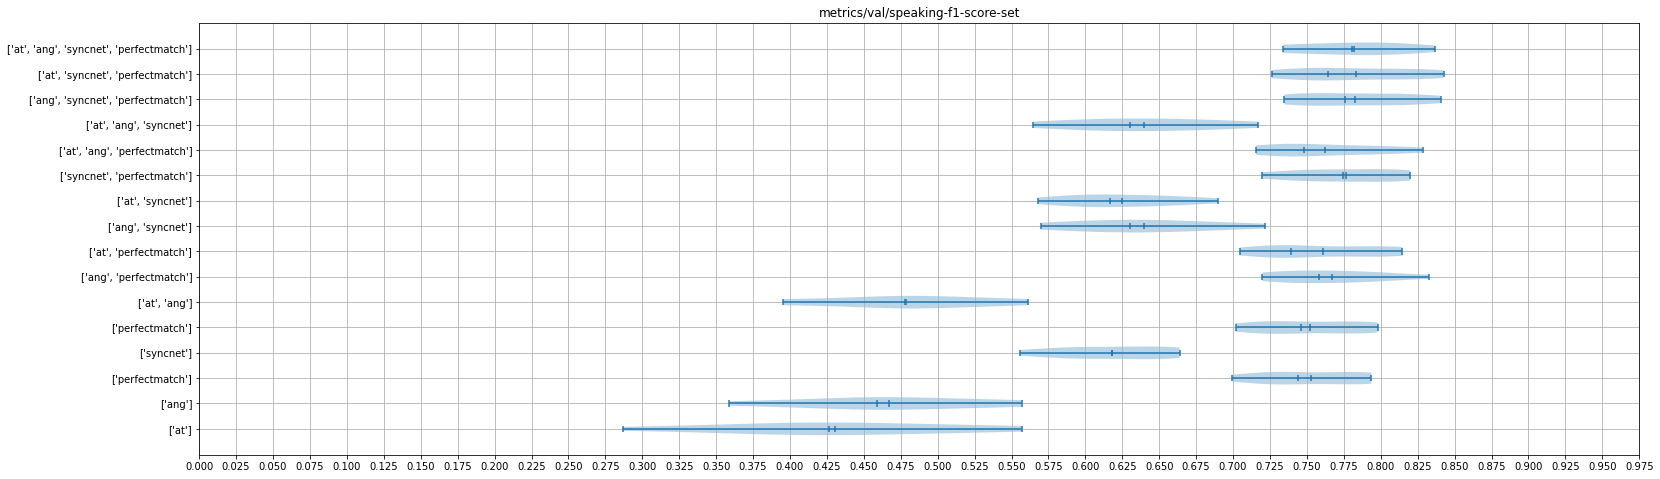

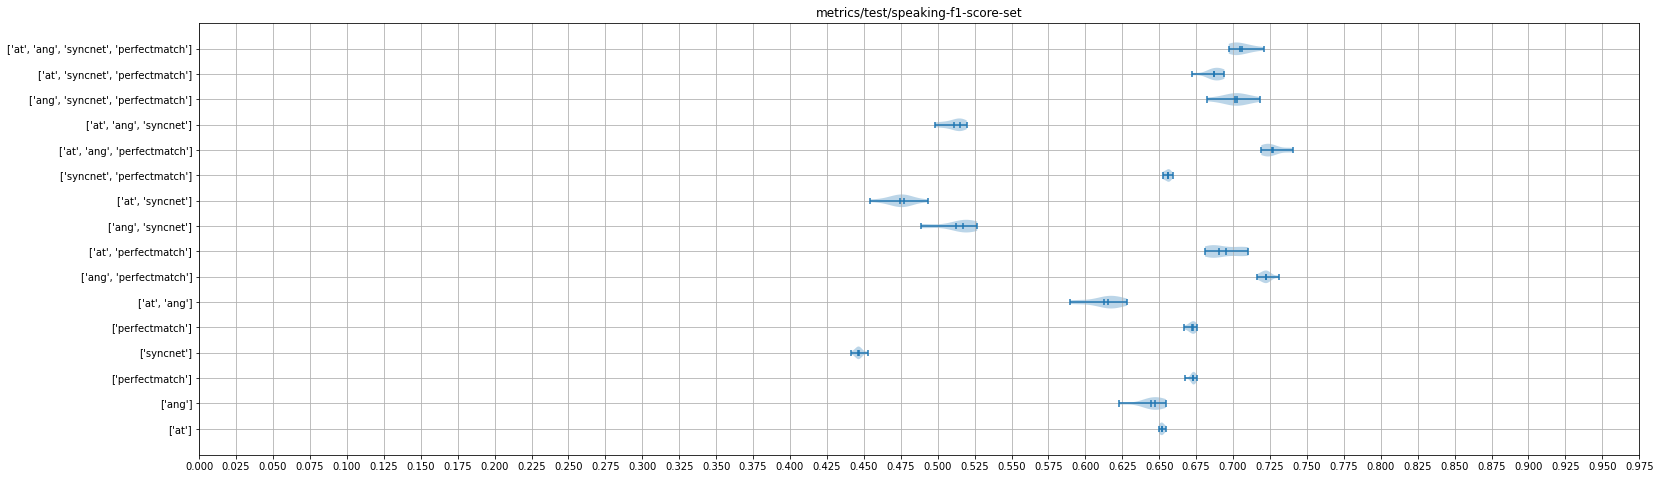

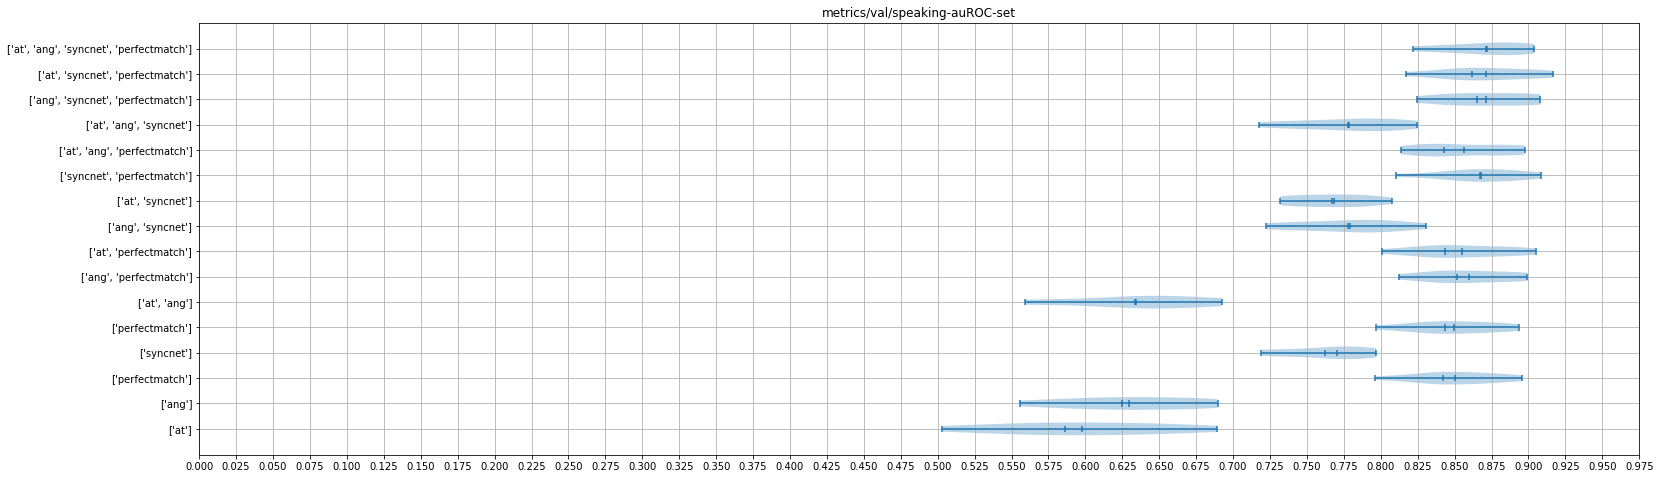

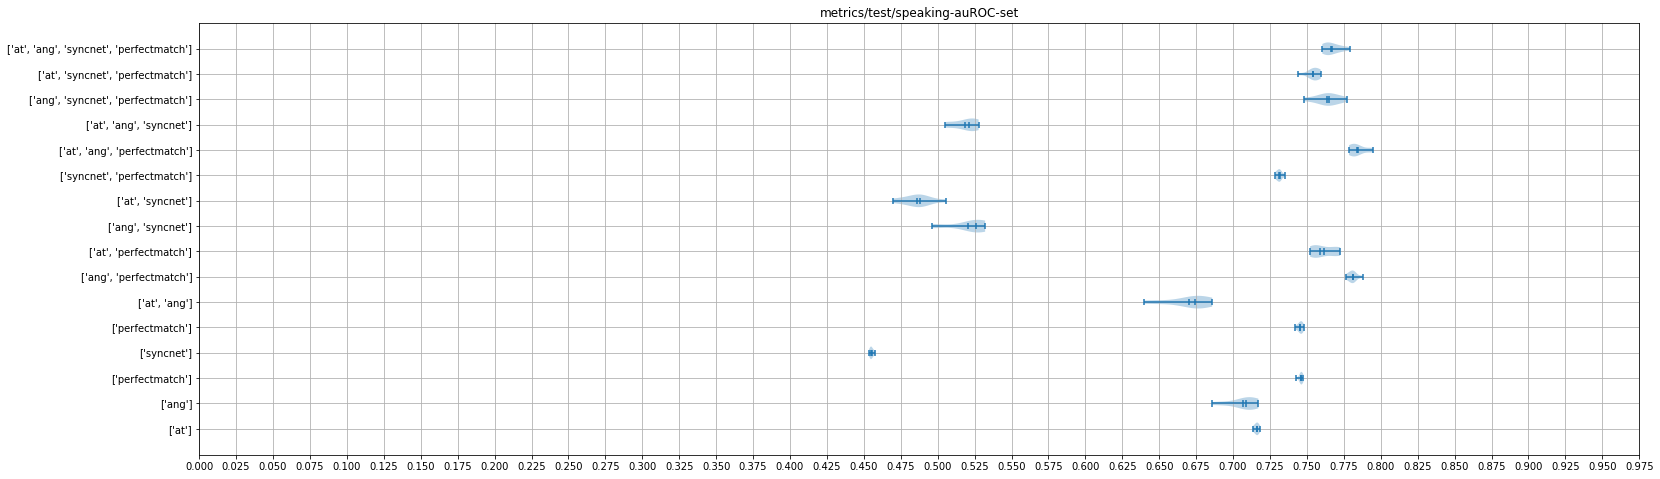

In [127]:
# xgb_12_table = get_table("xgb", "12", metrics)
for m in metrics:
    plot_table(xgb_12_table,m+"-set")

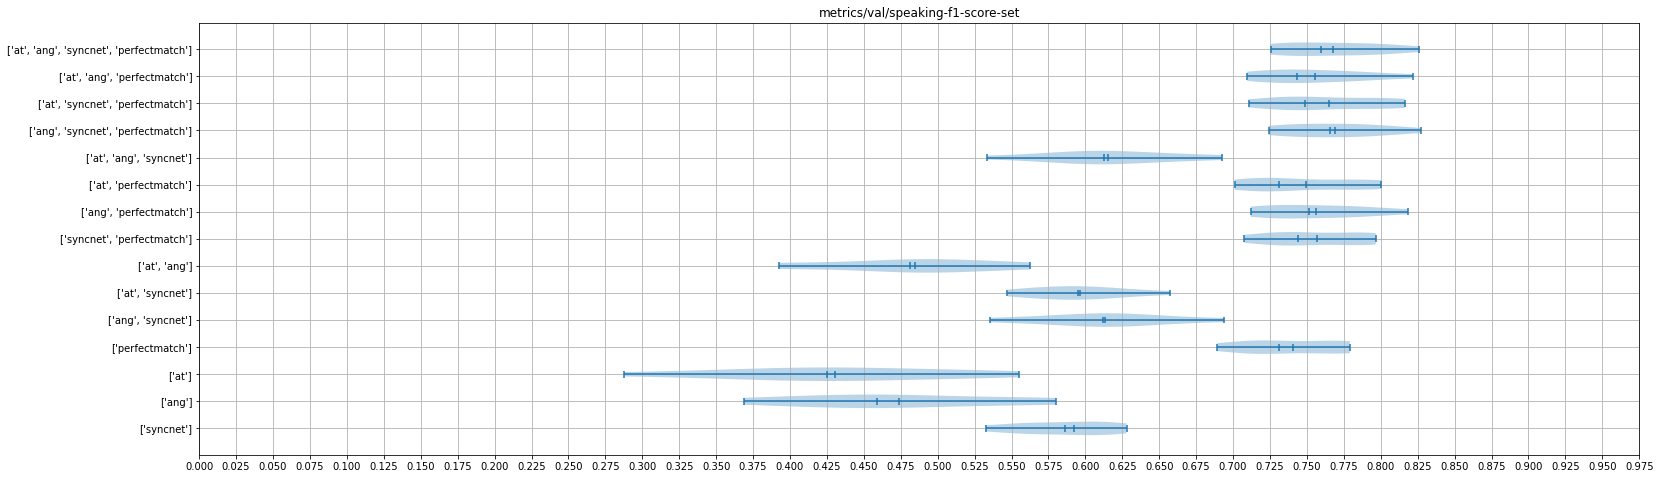

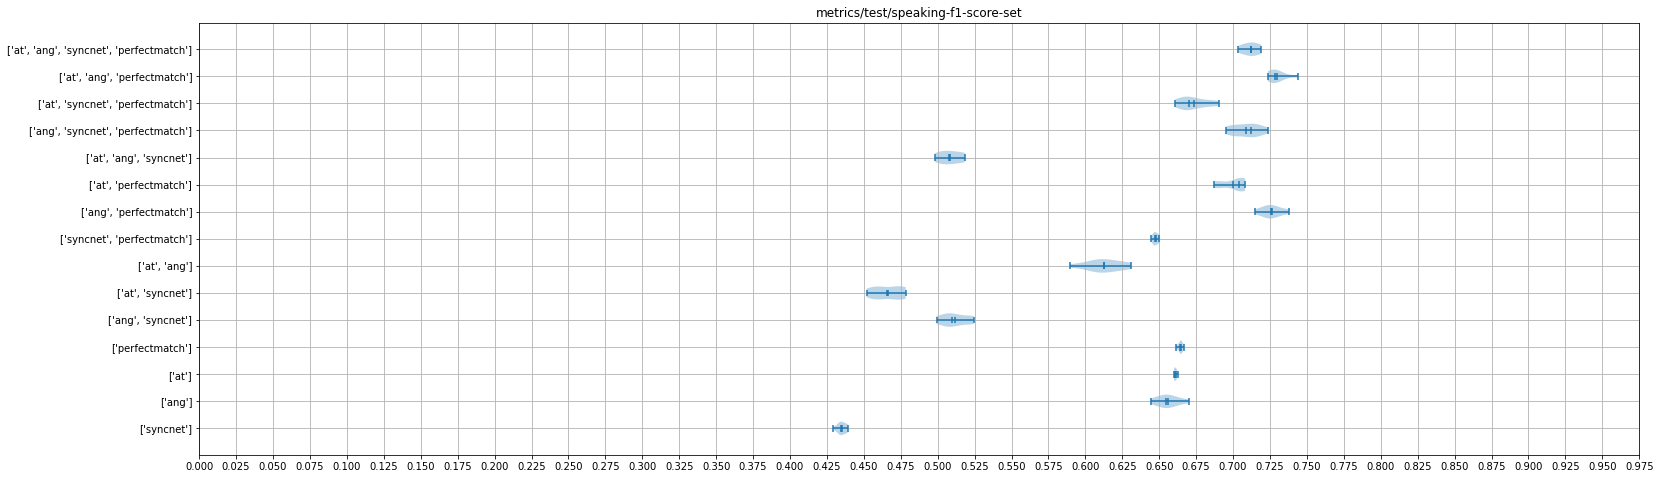

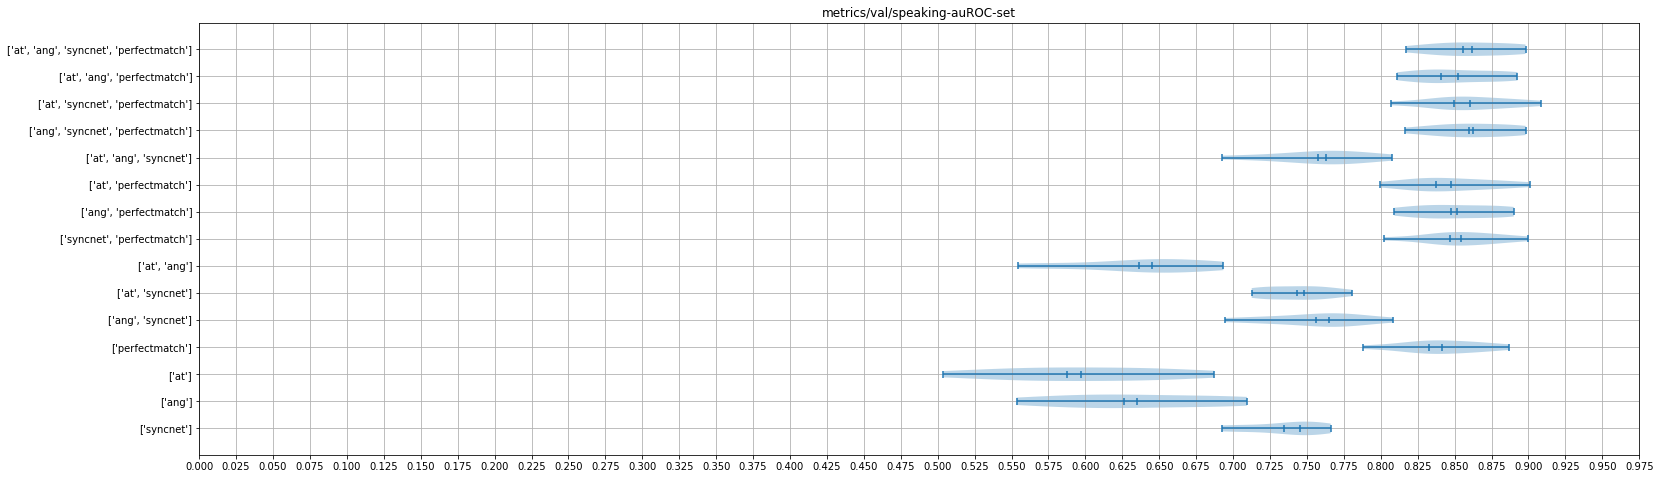

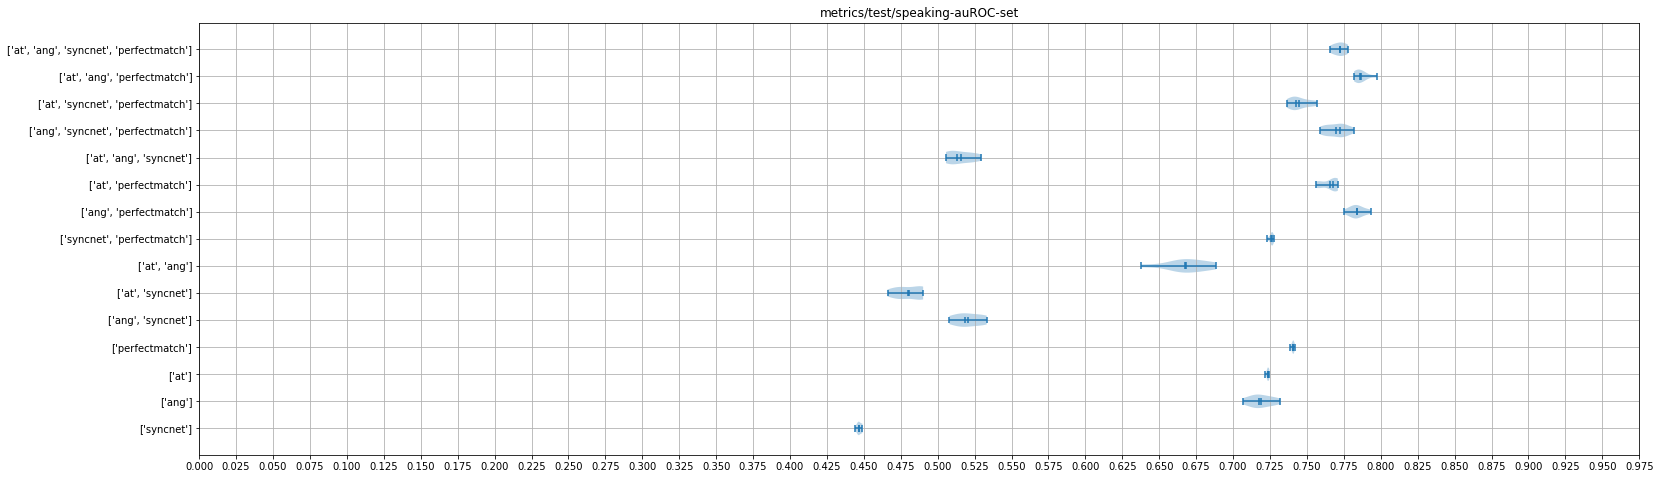

In [128]:
# xgb_5_table = get_table("xgb", "5", metrics)
for m in metrics:
    plot_table(xgb_5_table,m+"-set")

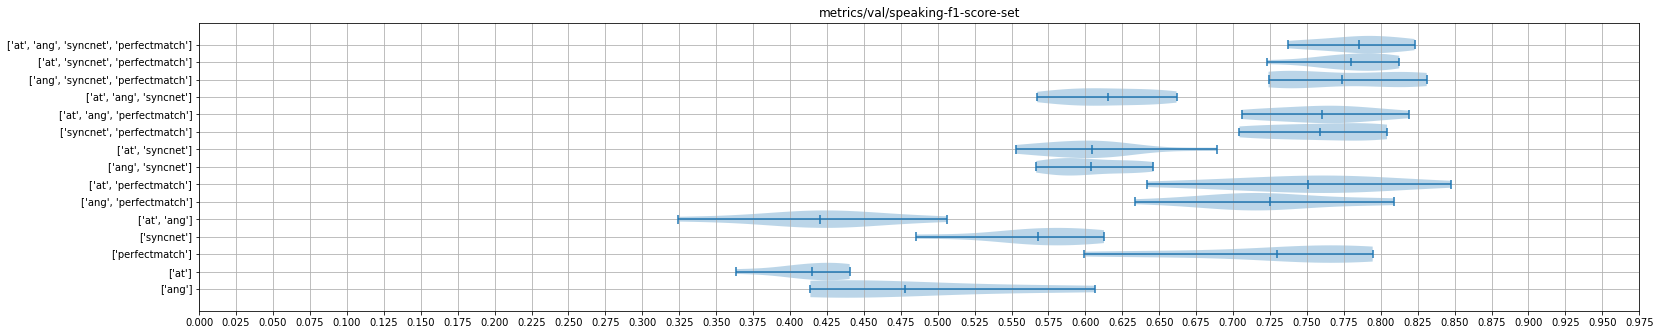

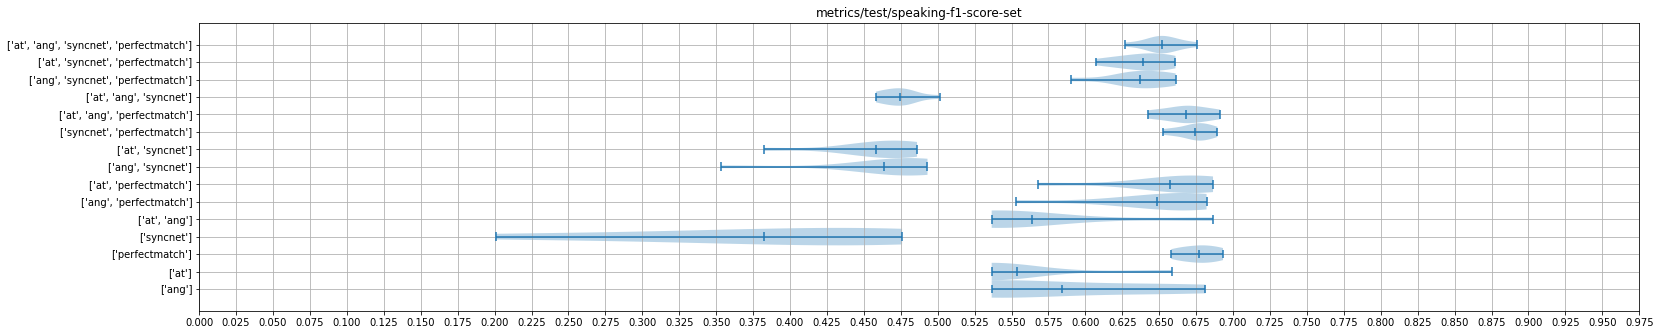

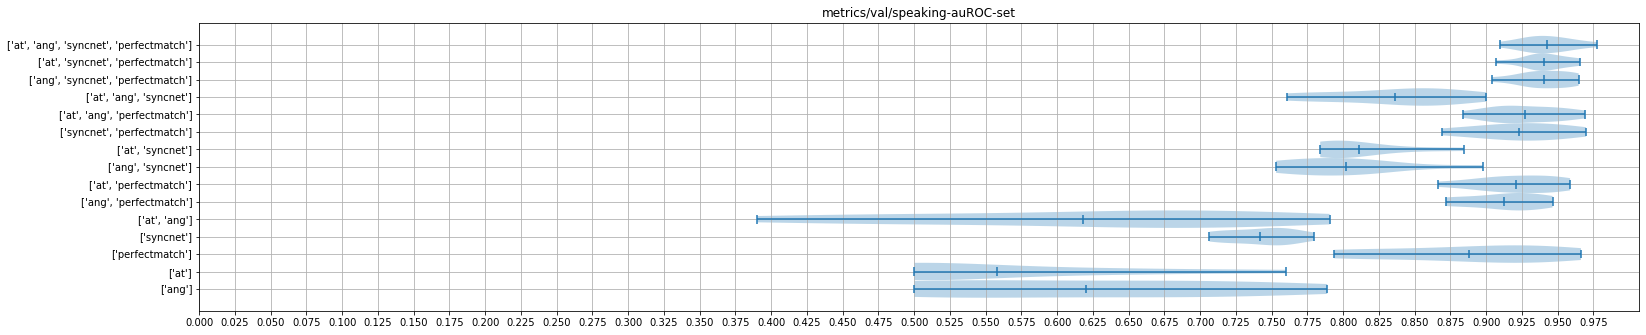

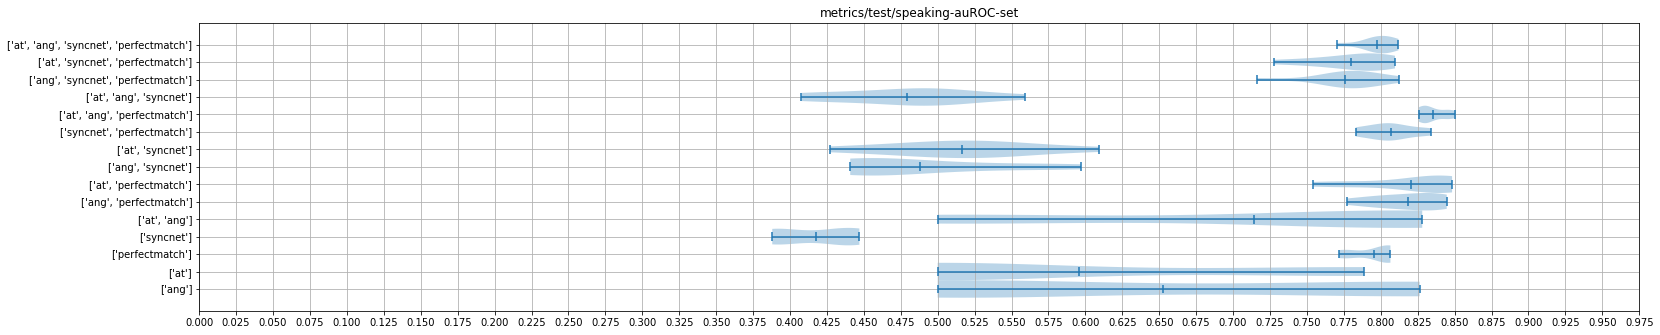

In [147]:
# tcn_25_table = get_table("tcn", "25", metrics)
for m in metrics:
    plot_table(tcn_25_table,m+"-set")

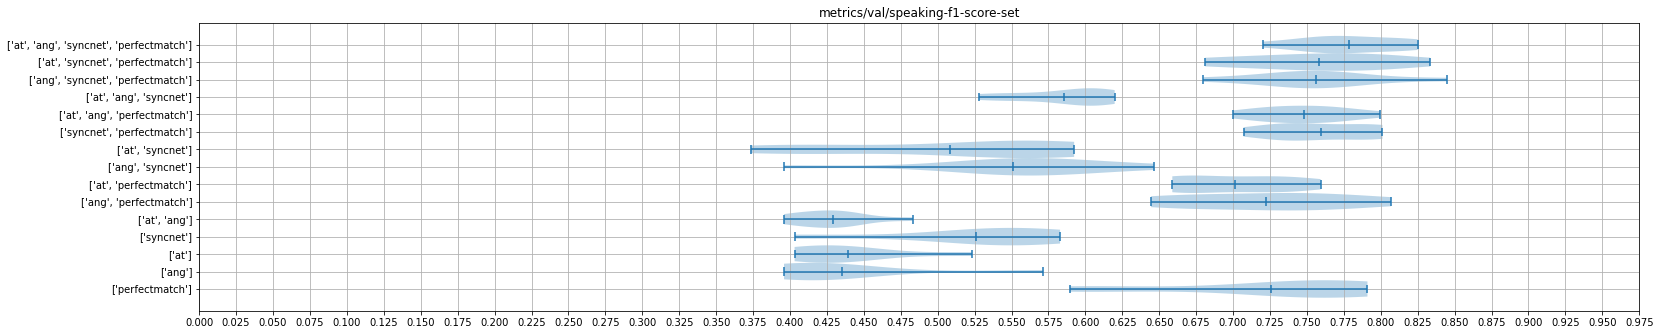

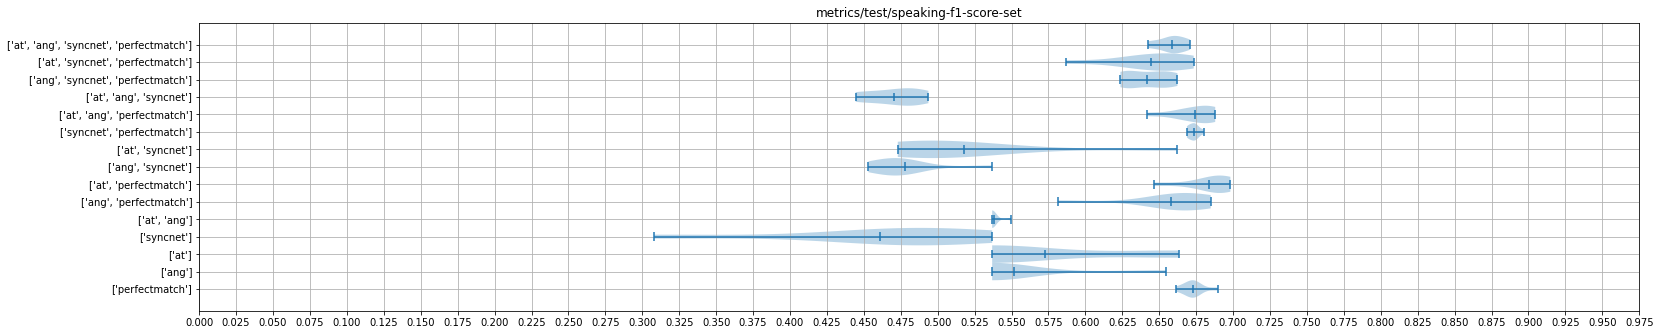

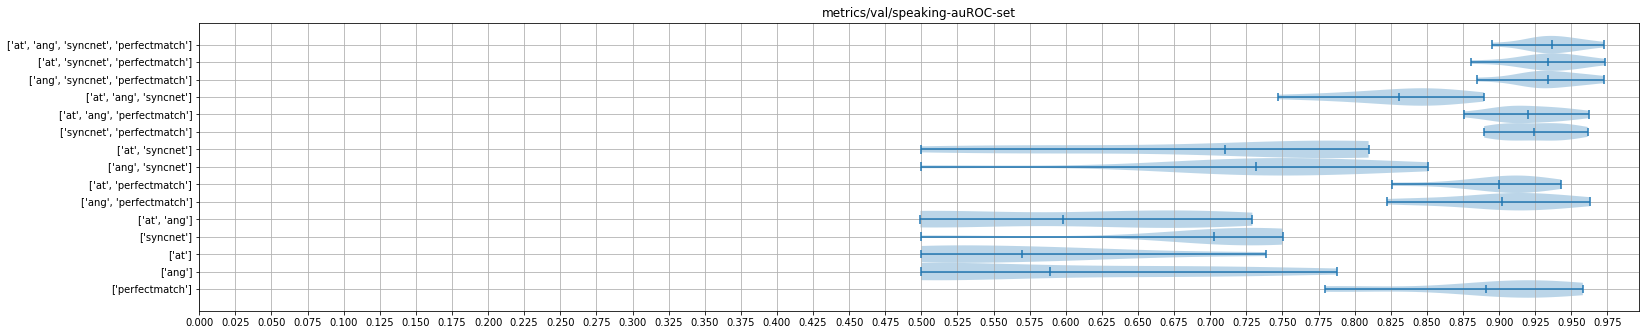

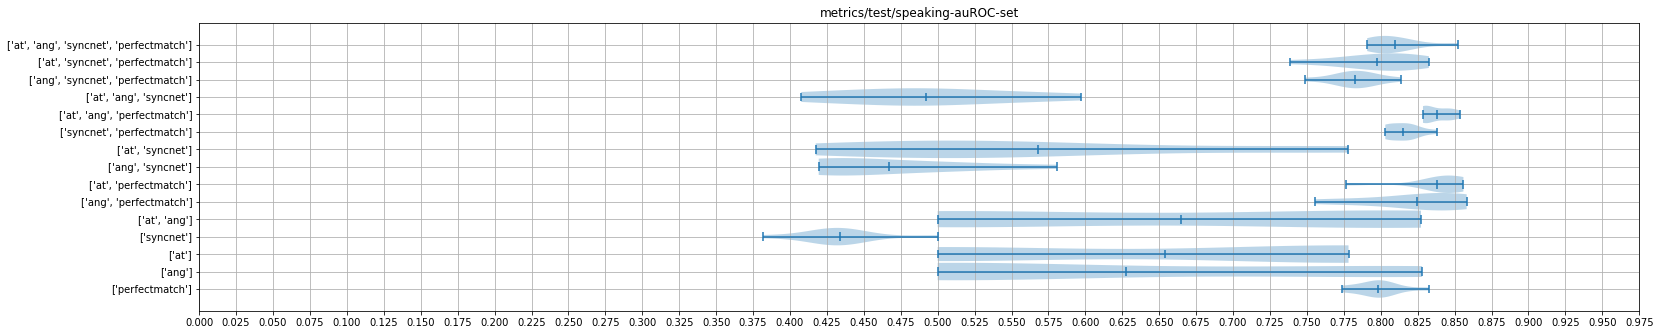

In [148]:
# tcn_12_table = get_table("tcn", "12", metrics)
for m in metrics:
    plot_table(tcn_12_table,m+"-set")

In [150]:
tcn_5_table = get_table("tcn", "5", metrics)
for m in metrics:
    plot_table(tcn_5_table,m+"-set")

OSError: [Errno 22] Invalid argument

# Recreating Visuals Functions

In [150]:

def get_text_channel(my_exp, channel_name):    
    channels_by_name = my_exp.get_channels()
    channel_id = channels_by_name[channel_name].id
    s = str(my_exp._backend.get_channel_points_csv(my_exp, channel_id).read())
    l = s.split("\n")[:-1]
    l = [i.split(",",1) for i in l]
    l = [[str(int(i[0][:-2])),i[1].replace("'",'"')] for i in l]
    l = {i[0]:json.loads(i[1]) for i in l}
    df = pd.DataFrame(l)
    df = df.T
    df.reset_index(inplace=True,drop=True)
    for c in df.columns:
        if is_numeric_dtype(df[c]):
            df[c] = pd.to_numeric(df[c])
    return df

def get_numeric_and_text(my_exp, keys_to_use=None):
    data_collected = my_exp.get_logs().keys()
    if not keys_to_use:
        keys_to_use = [k for k in data_collected if "f1" in k or "conf" in k]
    params_df = get_text_channel(my_exp, "run_parameters")
    results_df = my_exp.get_numeric_channels_values(*keys_to_use)
    final = pd.concat([results_df,params_df], axis=1)
    return final
# final = get_numeric_and_text(my_exp)


,x,val_speaking-conf-FN,val_speaking-conf-TP,val_speaking-f1-score,train_speaking-conf-FP,train_speaking-f1-score,test_speaking-conf-TN,val_speaking-conf-TN,train_speaking-conf-TN,test_speaking-conf-FN,...,train_speaking-conf-TP,train_speaking-conf-FN,max_depth,criterion,min_samples,window,max_features,r_win_size,step_size,sub_sample_neg_perc
0,0.0,3641.0,18873.0,0.756827,11256.0,0.896091,48598.0,47687.0,64284.0,3544.0,...,93642.0,10461.0,12,entropy,0.000119333,1,sqrt,28,5,75
1,1.0,250.0,3917.0,0.696603,8.0,0.972733,7060.0,7242.0,5819.0,394.0,...,17338.0,964.0,16,gini,0.000123911,27,auto,10,1,92
2,2.0,204.0,1458.0,0.746735,1417.0,0.821461,3387.0,3337.0,5108.0,332.0,...,5841.0,1122.0,11,gini,0.0342867,17,auto,16,4,74
3,3.0,540.0,5708.0,0.706479,9494.0,0.790942,11315.0,11406.0,21478.0,877.0,...,24747.0,3588.0,14,gini,0.0184381,9,auto,15,2,63
4,4.0,309.0,3710.0,0.730818,5999.0,0.810868,7425.0,7607.0,14998.0,519.0,...,16339.0,1623.0,8,entropy,0.00338956,14,auto,23,2,62
5,5.0,73.0,598.0,0.674944,1058.0,0.789518,1133.0,1166.0,1995.0,122.0,...,2320.0,179.0,4,entropy,0.00111929,28,log2,30,6,72
6,6.0,179.0,1773.0,0.717088,2763.0,0.803523,3556.0,3610.0,6812.0,279.0,...,7480.0,895.0,10,gini,0.00850271,29,log2,25,2,65
7,7.0,123.0,1002.0,0.765178,842.0,0.858503,2307.0,2316.0,3095.0,199.0,...,4059.0,496.0,5,gini,0.00331858,25,sqrt,15,4,78
8,8.0,38.0,864.0,0.653061,2652.0,0.715977,1176.0,1364.0,2883.0,63.0,...,3538.0,155.0,4,gini,0.10728,25,auto,6,5,57
9,9.0,81.0,738.0,0.720703,894.0,0.812618,1540.0,1540.0,2527.0,159.0,...,2808.0,401.0,11,gini,0.0162345,23,log2,9,6,74


In [166]:

def plot_par_cord(df, name='first_figure.html',color_metric='test_speaking-f1-score', columns_to_plot=None):
    dimensions = []
    if not columns_to_plot:
        columns_to_plot = df.columns
    for c in df.columns:
        if "conf" in c:
            continue
        elif is_numeric_dtype(df[c]):
            if "f1" in c or "auROC" in c or "AP" in c:
                r = [0,1]
            else:
                r = [df[c].min(),df[c].max()]
            dimensions.append(dict(
                label = c,
                range = r,
                values= df[c]
            ))
        elif is_string_dtype(df[c]):
            temp = pd.Categorical(df[c])
            dimensions.append(dict(
                label = c,
                tickvals = list(range(len(temp.categories.values))),
                ticktext = temp.categories.values,
                values = temp.codes
            ))


    
    fig = go.Figure(data=
        go.Parcoords(
            line = dict(color = df[color_metric],
                       colorscale = 'Electric',
                       showscale = True,
                       cmin = 0,
                       cmax = 1),
            dimensions = dimensions
        )
    )
    fig.write_html(name, auto_open=True)

In [168]:
# Tags of interest: 

speaking_exps = project.get_experiments(tag=['tcn','taking_yielding_holding_listening'])
for e in speaking_exps:
    print(e.get_tags())
my_exp = speaking_exps[-1]

data_collected = my_exp.get_logs().keys()
keys_to_use = [k for k in data_collected if "f1" in k or "conf" in k]

exp_df = get_numeric_and_text(my_exp, keys_to_use)

plot_par_cord(exp_df, color_metric='test_yielding-f1-score')

['Exp-1', 'pearson-m_hand-f', 'taking_yielding_holding_listening', '15 Trials', '23 Sessions', 'tcn']


In [132]:
len(t.categories.values[:])

2